# Neural machine translation with attention

https://www.tensorflow.org/text/tutorials/nmt_with_attention

use data from here : http://www.manythings.org/anki/

## Text reading and dataset creation

In [1]:
with open('MT/fra.txt') as file:
    lines = file.readlines()

lines[111]

'I paid.\tJe payai.\tCC-BY 2.0 (France) Attribution: tatoeba.org #5828610 (CK) & #7563049 (Micsmithel)\n'

In [2]:
def extract_source_target(lines):
    parts = [line.split('\t') for line in lines]
    Ss = [part[1] for part in parts]
    Ts = [part[0] for part in parts]
    return Ts, Ss

Ts, Ss = extract_source_target(lines)

Ts[111], Ss[111]

('I paid.', 'Je payai.')

In [3]:
import tensorflow as tf

BUFFER_SIZE = len(Ss)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((Ss, Ts)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.string)>

In [4]:
for S, T in dataset.take(1):
  print(S[:5])
  print()
  print(T[:5])
  break

tf.Tensor(
[b"J'ai peur des chiens." b'Je me suis enquis de son nom.'
 b"J'ai cherch\xc3\xa9 un g\xc3\xaete." b'Tu es un bon bassiste.'
 b'Avez-vous quelque chose \xc3\xa0 ajouter ?'], shape=(5,), dtype=string)

tf.Tensor(
[b"I'm afraid of dogs." b'I asked him his name.'
 b'I looked for a place to crash.' b"You're a good bass player."
 b'Do you have anything to add?'], shape=(5,), dtype=string)


## Text preprocessing

In [5]:
# normalize the unicode text in order to separate accents from letters
import tensorflow_text as tf_text

# normalization of unicode characters
example_text = tf.constant("Un élève est allé à l'école")

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b"Un \xc3\xa9l\xc3\xa8ve est all\xc3\xa9 \xc3\xa0 l'\xc3\xa9cole"
b"Un e\xcc\x81le\xcc\x80ve est alle\xcc\x81 a\xcc\x80 l'e\xcc\x81cole"


### Text normalization

In [6]:
# a normalization function
def tf_lower_and_split_punct(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    text = tf.strings.join(['<s>', text, '</s>'], separator=' ')
    return text

tf_lower_and_split_punct("Un élève est allé à l'école")

<tf.Tensor: shape=(), dtype=string, numpy=b'<s> un eleve est alle a lecole </s>'>

### Text Vectorization

In [7]:
from tensorflow.keras.layers.experimental import preprocessing
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [8]:
# train the preprocessor on the input vocabulary for french
input_text_processor.adapt(S)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '<s>', '</s>', '.', 'je', 'de', 'a', 'que', '?']

In [9]:
# another for english
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(T)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '<s>', '</s>', '.', 'i', 'to', 'you', 'the', '?']

In [10]:
example_tokens = input_text_processor(S)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  2,  28, 117,  22, 220,   4,   3,   0,   0,   0],
       [  2,   5,  21,  20, 201,   6,  78, 133,   4,   3],
       [  2,  28, 221,  13, 182,   4,   3,   0,   0,   0]])>

In [11]:
# To get the text from the encoding
import numpy as np

input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'<s> jai peur des chiens . </s>              '

Text(0.5, 1.0, 'Mask')

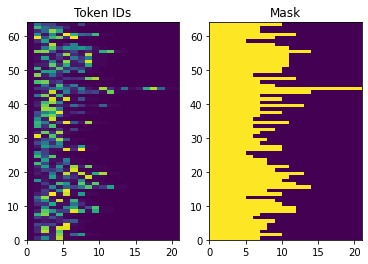

In [12]:
# the texts are zero-padded into the max length
# just to plot the padding using a mask
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

## The encoder/decoder model

### The encoder

In [13]:
embedding_dim = 256
units = 1024

class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        
        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
    def call(self, tokens, state=None):

        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)

        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)

        # 4. Returns the new sequence and its state.
        return output, state

In [14]:
# Convert the input text to tokens.
example_tokens = input_text_processor(S)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {S.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 21)
Encoder output, shape (batch, s, units): (64, 21, 1024)
Encoder state, shape (batch, units): (64, 1024)


### The decoder

In [15]:
import typing
from typing import Any, Tuple

class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [16]:
class Decoder(tf.keras.layers.Layer):
    
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer convets token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

        # For step 3. The RNN output will be the query for the attention layer.
        #self.attention = BahdanauAttention(self.dec_units)
        self.attention = tf.keras.layers.AdditiveAttention()

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)
        
        
    def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:

        # Step 1. Lookup the embeddings
        vectors = self.embedding(inputs.new_tokens)

        # Step 2. Process one step with the RNN
        rnn_output, state = self.gru(vectors, initial_state=state)

        # Step 3. Use the RNN output as the query for the attention over the
        # encoder output.
#         context_vector, attention_weights = self.attention(
#             query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
        query_mask = tf.ones(tf.shape(rnn_output)[:-1], dtype=bool)
        context_vector, attention_weights = self.attention(
            [rnn_output, inputs.enc_output], mask=[query_mask, inputs.mask], return_attention_scores=True)

        # Step 4. Eqn. (3): Join the context_vector and rnn_output
        #     [ct; ht] shape: (batch t, value_units + query_units)
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

        # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
        attention_vector = self.Wc(context_and_rnn_output)

        # Step 5. Generate logit predictions:
        logits = self.fc(attention_vector)

        return DecoderOutput(logits, attention_weights), state
    

In [17]:
#attention = tf.keras.layers.AdditiveAttention()
decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)

In [18]:
# Convert the target sequence, and collect the "<s>" tokens
example_output_tokens = output_text_processor(T)

start_index = output_text_processor.get_vocabulary().index('<s>')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [19]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 223)
state shape: (batch_size, dec_units) (64, 1024)


## Training

### Loss Function

In [20]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

### Training step

In [21]:
class TrainTranslator(tf.keras.Model):
    
    def __init__(self, embedding_dim, units, input_text_processor, output_text_processor, use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        self.encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
        self.decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        
    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

    def _train_step(self, inputs):
        input_text, target_text = inputs  

        (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(input_text, target_text)
        max_target_length = tf.shape(target_tokens)[1]

        with tf.GradientTape() as tape:
            # Encode the input
            enc_output, enc_state = self.encoder(input_tokens)

            # Initialize the decoder's state to the encoder's final state.
            # This only works if the encoder and decoder have the same number of units.
            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in tf.range(max_target_length-1):
                # Pass in two tokens from the target sequence:
                # 1. The current input to the decoder.
                # 2. The target for the decoder's next prediction.
                new_tokens = target_tokens[:, t:t+2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask, enc_output, dec_state)
                loss = loss + step_loss

            # Average the loss over all non padding tokens.
            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

        # Apply an optimization step
        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        # Return a dict mapping metric names to current value
        return {'batch_loss': average_loss}
    
    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)
    
    def _preprocess(self, input_text, target_text):

        # Convert the text to token IDs
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)

        # Convert IDs to masks.
        input_mask = input_tokens != 0
        target_mask = target_tokens != 0

        return input_tokens, input_mask, target_tokens, target_mask
    
    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

        # Run the decoder one step.
        decoder_input = DecoderInput(new_tokens=input_token, enc_output=enc_output, mask=input_mask)

        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

        # `self.loss` returns the total for non-padded tokens
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)

        return step_loss, dec_state
    
    

### Test the model

In [22]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor, use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [23]:
%%time
for n in range(10):
    print(translator.train_step([S, T]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8155303>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.74757>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.624718>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.310902>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2736177>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.929989>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0054016>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9556723>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.866697>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7955484>}

CPU times: user 1min 3s, sys: 1.56 s, total: 1min 5s
Wall time: 22.8 s


### Train the model

In [24]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [25]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [26]:
train_translator.fit(dataset, epochs=3, callbacks=[batch_loss])
#train_translator.fit(x=Ss, y=Ts, batch_size=BATCH_SIZE, epochs=3)

Epoch 1/3
2972/2972 [==============================] - 5481s 2s/step - batch_loss: 1.2779
Epoch 2/3
2972/2972 [==============================] - 5347s 2s/step - batch_loss: 0.9117
Epoch 3/3
2972/2972 [==============================] - 5384s 2s/step - batch_loss: 0.7718


Text(0, 0.5, 'CE/token')

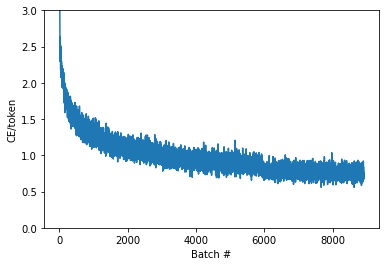

In [27]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

## Translate

In [42]:
class Translator(tf.Module):

    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '<s>']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('<s>'))
        self.end_token = index_from_string(tf.constant('</s>'))
        
    def tokens_to_text(self, result_tokens):
        result_text_tokens = self.output_token_string_from_index(result_tokens)
        result_text = tf.strings.reduce_join(result_text_tokens, axis=1, separator=' ')
        result_text = tf.strings.strip(result_text)
        return result_text
    
    def sample(self, logits, temperature):
        token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
        
        # Set the logits for all masked tokens to -inf, so they are never chosen.
        logits = tf.where(self.token_mask, -np.inf, logits)

        if temperature == 0.0:
            new_tokens = tf.argmax(logits, axis=-1)
        else: 
            logits = tf.squeeze(logits, axis=1)
            new_tokens = tf.random.categorical(logits/temperature, num_samples=1)

        return new_tokens

    def translate(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)

        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)

        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)

        for _ in range(max_length):
            dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

            dec_result, dec_state = self.decoder(dec_input, state=dec_state)

            attention.append(dec_result.attention_weights)

            new_tokens = self.sample(dec_result.logits, temperature)

            # If a sequence produces an `end_token`, set it `done`
            done = done | (new_tokens == self.end_token)
            # Once a sequence is done it only produces 0-padding.
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

            # Collect the generated tokens
            result_tokens.append(new_tokens)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Convert the list of generates token ids to a list of strings.
        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)

        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}
    
    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def tf_translate(self, input_text):
        return self.translate(input_text)
    

In [43]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [59]:
%%time
input_text = tf.constant([
    'le temps est bon.',
    'la vie est belle.', 
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

time is good .
a no time is open .

CPU times: user 258 ms, sys: 144 µs, total: 258 ms
Wall time: 162 ms


## Evaluation

### Visualization

In [60]:
# Visualization
# return the attention for the first sentence
a = result['attention'][0]

<ipython-input-61-11c6ad61c3ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-61-11c6ad61c3ef>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


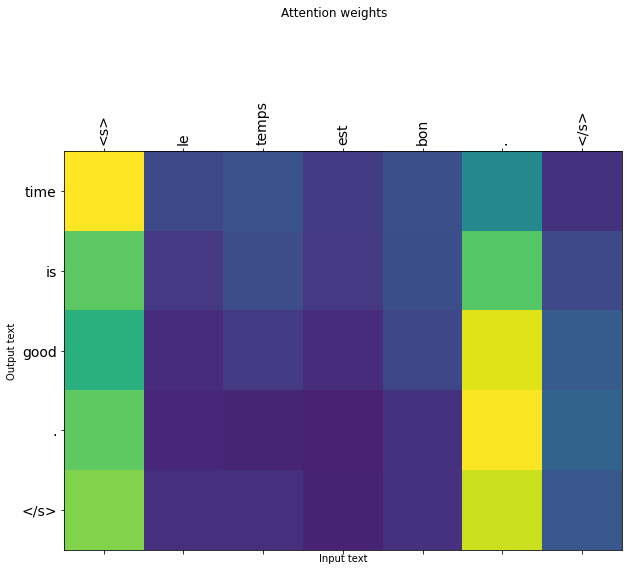

In [61]:
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['</s>']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)

    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

plot_attention(result['attention'][0], input_text[0], result['text'][0])

### BLEU

In [64]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

estimate = result['text'][0].numpy().decode().split()
sentence_bleu(['the weather is good .'.split(), 'weather is good .'.split()], estimate)

8.636168555094496e-78

In [55]:
## Saving and recovering

In [51]:
path = '/home/kariminf/Data/tutoriel/keras_translator'

In [50]:
tf.saved_model.save(translator, path,
                    signatures={'serving_default': translator.tf_translate})

INFO:tensorflow:Assets written to: /home/kariminf/Data/tutoriel/keras_translator/assets


INFO:tensorflow:Assets written to: /home/kariminf/Data/tutoriel/keras_translator/assets


In [52]:
reloaded = tf.saved_model.load(path)

In [54]:
result = reloaded.tf_translate(tf.constant([
    'le temps est bon.', # "It's cold."
    'la vie est belle.', # "life is good.""
]))

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

time is good .
the proof is clear .

